# Midterm Exam (part 2) - Analysis

### Name: Rolando Sánchez

The structure of the module `orbit.py` is the following: <br>
```
orbit/                          # Root package directory
│
├── orbit/                      # Main module package
│   ├── __init__.py             # Package initialization
│   └── orbit,py                # Main module/script
│
├── tests/                      # Unit and integration tests
│   ├── __init__.py
│   └── test_orbit.py           # Test plotting/animation
│
├── examples/                   # Example scripts and notebooks
│   ├── config.ini              # Cofig file to initialize script
│   ├── basic_usage.py          # Minimal usage example
│   ├── example_output/
│   │  └
│   └── basic_usage.ipynb       # Advanced example in notebook
│
├── analysis.ipynb              # Analysis Python Notebook
│
├── .gitignore                  # Ignore build/dist files
├── setup.py                    # Package installation
├── README.md                   # Project overview
└── LICENSE                     # BSD license

```

(i) Use your module/script to run and show two simulations: one relativistic and one classical for this set of initial conditions. It may be helpful to compare the orbital history in a single plot.

| Parameter | Description                                       | Units      |
|-----------|---------------------------------------------------|------------|
| $e$       | Eccentricity of the orbit                         | $0$        |
| $M$       | Mass of the central black hole                    | $5\times 10^6\,\rm M_\odot$ |
| $a$       | Semi-major axis of the orbit                      | $1\,\rm AU$|
| $N$       | Number of orbital periods to simulate             | $2$        |
| Method    | Numerical method for ODE integration              | RK3        |

In [80]:
import orbit
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
import os

In [59]:
# Let's define the parameters for the simulations
e_sim = 0.
m_sim = 5e6 
a_sim = 1
n_sim = 2
method_sim = "scipy"

# Let's define a folder to save the results
analysis_output = "./analysis_output"
# And tnames for the vtk files generated
classical_vtk = "classical_orbit"
relativistic_vtk = "relativistic_orbit"

In [60]:
# Let's create an instance of our class
simulations_tbp = orbit.TwoBodyProblem(m_sim, a_sim, e_sim)

In [81]:
sol_classical = orbit.RunIntegrator(n_sim, False, None, simulations_tbp, method_sim, analysis_output, classical_vtk, None) # Classical orbit
sol_relativistic = orbit.RunIntegrator(n_sim, True, None, simulations_tbp, method_sim, analysis_output, relativistic_vtk, None) # Relativistic orbit

# Run
s_c, t_c = sol_classical.run()
s_r, t_r = sol_relativistic.run()

# Get Swarzchild radius from vtk files, please modify this if the output directory with the generated vtk files is different. 
r_s =  pv.read("./analysis_output/relativistic_orbit.vtk").field_data['schwarzschild_radius'][0]

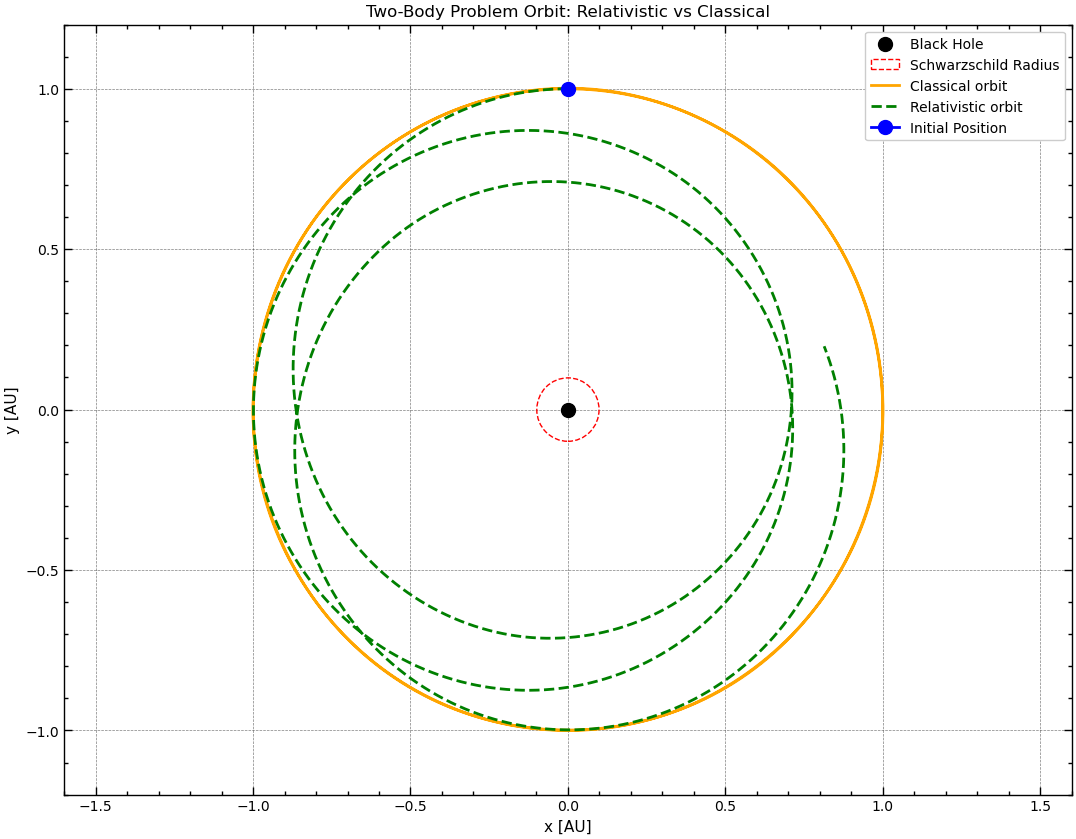

In [89]:
# Create plot
fig, ax = plt.subplots(figsize=(13,10))
ax.set_xlim(-1.6 * a_sim * np.sqrt(1 - e_sim**2), 1.6 * a_sim * np.sqrt(1 - e_sim**2))
ax.set_ylim(-1.2 * a_sim * (1 + e_sim), 1.2 * a_sim * (1 - e_sim))
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")
ax.set_title("Two-Body Problem Orbit: Relativistic vs Classical")
# Plot central black hole and Schwarzschild radius
ax.scatter(0, 0, color='k', s=100, label="Black Hole")
schwarzschild_circle = plt.Circle((0, 0), r_s, color='r', fill=False, linestyle='dashed', label="Schwarzschild Radius")
ax.add_patch(schwarzschild_circle)
# Plot initial position of planet
ax.plot(s_c[:,0,0], s_c[:,0,1], color = "orange", label = "Classical orbit")
ax.plot(s_r[:,0,0], s_r[:,0,1], color = "green", label = "Relativistic orbit", linestyle = "--")
ax.plot(s_c[0,0,0], s_c[0,0,1], color = "blue", label = "Initial Position", marker = ".", markersize = 20)
ax.legend()
plt.show()
plt.close()


(j) Use the orbital history of both simulations to design a method that quantifies their differences and evaluates the importance of using the relativistic approach for massive objects. Do we need to worry about the relativistic corrections if we replace the black hole with our Sun?

In [63]:
def compare_orbits(t_class, r_class, t_rel, r_rel):
    """
    Quantifies differences between classical and relativistic orbits.
    
    Args:
        t_class, t_rel: Time arrays for both simulations
        r_class, r_rel: Position arrays (shape [N,3] for N time steps)
    
    Returns:
        dict: Metrics including precession, RMSD, etc.
    """
    # Interpolate to common time grid
    t_common = np.linspace(max(t_class.min(), t_rel.min()), 
                          min(t_class.max(), t_rel.max()), 
                          len(t_class))
    r_class_interp = np.array([np.interp(t_common, t_class, r_class[:, i]) for i in range(2)]).T
    r_rel_interp = np.array([np.interp(t_common, t_rel, r_rel[:, i]) for i in range(2)]).T
    
    # Calculate metrics
    rmsd = np.sqrt(np.mean(np.sum((r_class_interp - r_rel_interp)**2, axis=1)))
    max_deviation = np.max(np.linalg.norm(r_class_interp - r_rel_interp, axis=1))
    
    # Perihelion precession (approximate)
    perihelion_class = r_class[np.argmin(np.linalg.norm(r_class, axis=1))]
    perihelion_rel = r_rel[np.argmin(np.linalg.norm(r_rel, axis=1))]
    precession_angle = np.arccos(np.dot(perihelion_class, perihelion_rel) / 
                       (np.linalg.norm(perihelion_class) * np.linalg.norm(perihelion_rel)))
    
    return {
        "rmsd": rmsd,                          # Average path deviation
        "max_deviation": max_deviation,        # Worst-case deviation
        "precession_angle": precession_angle,  # In radians
    }


### The role of eccentricity (3 points):

(k) Use your module/script to run and show three relativistic simulations for objects with different eccentricities, $e$, and assuming the same $M$, $a$, $N$ as above. It may be helpful to compare the orbital history for all values of $e$ in a single plot throughout time.

| Object           | Eccentricity ($e$) | Integration Method |
|------------------|--------------------|--------------------|
| Earth            | 0.01671            | Trapezoidal        |
| Pluto            | 0.25               | Trapezoidal        |
| 7092 Cadmus      | 0.70               | Trapezoidal        |

In [71]:
# Let's create an instance of our class with the different eccentricities
e_earth = 0.01671
rel_sim_earth = orbit.TwoBodyProblem(m_sim, a_sim, e_earth)
e_pluto = 0.25
rel_sim_pluto = orbit.TwoBodyProblem(m_sim, a_sim, e_pluto)
e_cadmus = 0.70
rel_sim_cadmus = orbit.TwoBodyProblem(m_sim, a_sim, e_cadmus)

In [72]:
sol_earth = orbit.RunIntegrator(n_sim, True, None, rel_sim_earth, "trapezoidal", analysis_output, "orbit_earth", None) # Earth's orbit
sol_pluto = orbit.RunIntegrator(n_sim, True, None, rel_sim_pluto, "trapezoidal", analysis_output, "orbit_pluto", None) # Pluto's orbit
sol_cadmus = orbit.RunIntegrator(n_sim, True, None, rel_sim_cadmus, "trapezoidal", analysis_output, "orbit_cadmus", None) # Cadmus's orbit
# Run
s_earth, t_earth = sol_earth.run()
s_pluto, t_pluto = sol_pluto.run()
s_cadmus, t_cadmus = sol_cadmus.run()

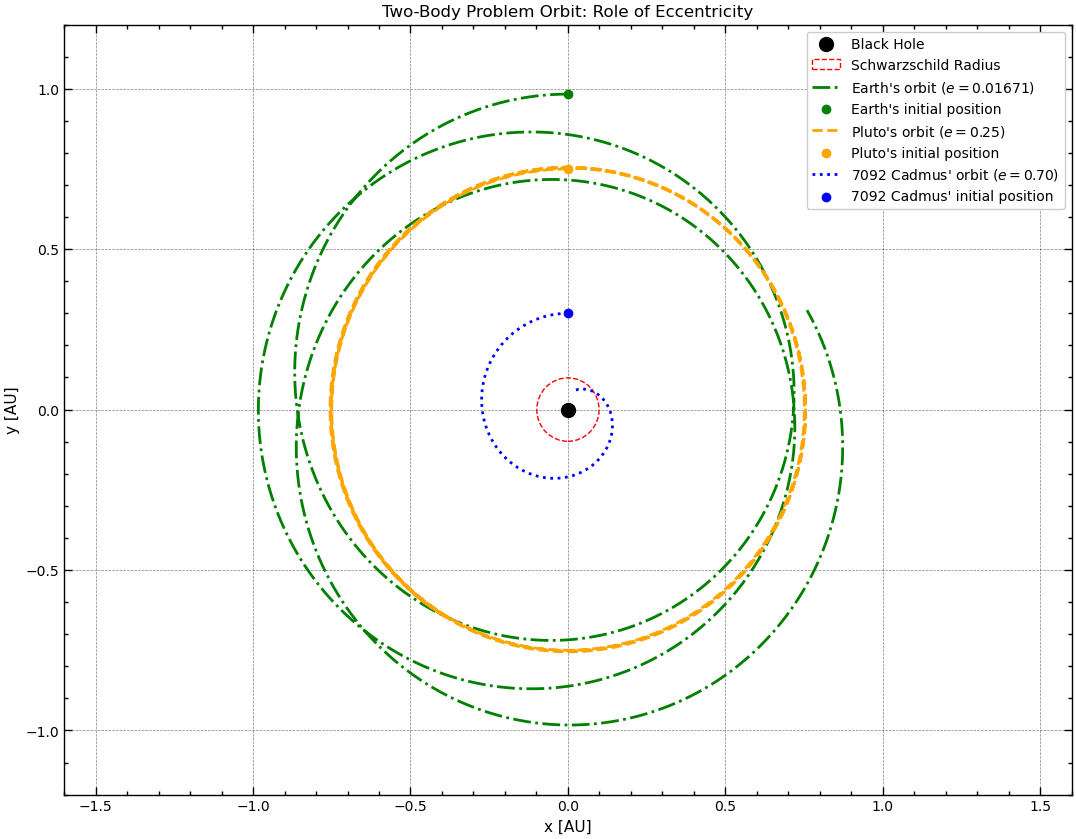

In [90]:
# Create plot
fig, ax = plt.subplots(figsize=(13,10))
ax.set_xlim(-1.6 * a_sim * np.sqrt(1 - e_sim**2), 1.6 * a_sim * np.sqrt(1 - e_sim**2))
ax.set_ylim(-1.2 * a_sim * (1 + e_sim), 1.2 * a_sim * (1 - e_sim))
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")
ax.set_title("Two-Body Problem Orbit: Role of Eccentricity")
# Plot central black hole and Schwarzschild radius
ax.scatter(0, 0, color='k', s=100, label="Black Hole")
schwarzschild_circle = plt.Circle((0, 0), r_s, color='r', fill=False, linestyle='dashed', label="Schwarzschild Radius")
ax.add_patch(schwarzschild_circle)
# Plot initial position of planet
ax.plot(s_earth[:,0,0], s_earth[:,0,1], color = "green", label = r"Earth's orbit ($e = 0.01671$)", linestyle = "-.")
ax.scatter(s_earth[0,0,0], s_earth[0,0,1], color = "green", label = "Earth's initial position")

ax.plot(s_pluto[:,0,0], s_pluto[:,0,1], color = "orange", label = r"Pluto's orbit ($e = 0.25$)", linestyle = "--")
ax.scatter(s_pluto[0,0,0], s_pluto[0,0,1], color = "orange", label = "Pluto's initial position")

ax.plot(s_cadmus[:,0,0], s_cadmus[:,0,1], color = "blue", label = r"7092 Cadmus' orbit ($e = 0.70$)", linestyle = ":")
ax.scatter(s_cadmus[0,0,0], s_cadmus[0,0,1], color = "blue", label = "7092 Cadmus' initial position")

ax.legend()
plt.show()
plt.close()

(l) Describe the differences in the orbits of the above objects. What happens to objects with high eccentricities?


sol_earth = orbit.RunIntegrator(n_sim, True, None, rel_sim_earth, "trapezoidal", analysis_output, "orbit_earth", None) # Earth's orbit
sol_pluto = orbit.RunIntegrator(n_sim, True, None, rel_sim_pluto, "trapezoidal", analysis_output, "orbit_pluto", None) # Pluto's orbit
sol_cadmus = orbit.RunIntegrator(n_sim, True, None, rel_sim_cadmus, "trapezoidal", analysis_output, "orbit_cadmus", None) # Cadmus's orbit
# Run
s_earth, t_earth = sol_earth.run()
s_pluto, t_pluto = sol_pluto.run()
s_cadmus, t_cadmus = sol_cadmus.run()

### Numerical convergence (3 points):

(m) Use your script to generate additional simulations with the same initial conditions as before, but only for $e=0.01671$ (Earth's eccentricity) with RK3, the Trapezoidal method and the higher-order SciPy integrator. Compare the orbital history for all methods in a single plot throughout time.

(n) Measure convergence of the simulations with RK3 and Trapezoidal method for $e=0.01671$ by integrating at a number of different time steps. To analyse convergence, you need to define some measure for the error with respect to the higher order method, and then plot it against different time steps for both methods. Thus, you may add additional functions for this to your code in **orbits.py**. 

**Note:** Please include all your simulation outputs in the **outputfolder** for a reference.


### Exam submission:

- Send your code **in a single .tar ball file via email** to wbanda@yachaytech.edu.ec by the deadline.